**Date** 2026-01  
**Objective** 1d grid cann translated from Matlab codes  
**References**: Burak Y, Fiete IR. Accurate path integration in continuous attractor network models of grid cells. PLoS Comput Biol. 2009 Feb;5(2):e1000291. doi: 10.1371/journal.pcbi.1000291. Epub 2009 Feb 20. PMID: 19229307; PMCID: PMC2632741.  

This notebook documents the translation of a one-dimensional grid-cell continuous attractor neural network from the original MATLAB implementation into Python. 


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from scipy.stats import poisson
from datetime import datetime


### Generate Trajectories

In [ ]:
# Temporal parameters
T = 100            # length of integration time blocks (s)
dt = 1/2000        # step size of numerical integration (s) =0.5ms
tau_s = 30/1000    # synaptic time constant (s)


In [3]:
# Trajectory Data 
time_steps = np.arange(dt, T + dt, dt)

# Generate synthetic trajectory data: sine wave or flat
x = (np.sin(time_steps * 2 * np.pi / 10) + 1) / 2  # generate sine wave
# x = np.zeros(len(time_steps))  # flat trajectory

# Calculate velocity
v = np.zeros_like(x)
v[1:] = (x[1:] - x[:-1]) / dt  # more efficient than loop


## Burak, 2009

### Equations

#### **Weight Kernel**

Given the periodic index $z \in [-\tfrac{N}{2}, \tfrac{N}{2})$, the double-ring weight kernel is
$$
K(z)=\alpha\left(\bar{\alpha}\, e^{-\gamma z^{2}/\sigma_1^{2}}- e^{-\beta_w z^{2}/\sigma_2^{2}}\right).
$$
+ Each weight matrix is produced by circularly shifting $K(z)$, for example
+ $$W_{\mathrm{RR}}(i,j)=K\!\left((j-i+1)\!\!\bmod N\right),\qquad W_{\mathrm{LL}}(i,j)=K\!\left((j-i-1)\!\!\bmod N\right)$$
+ while $W_{\mathrm{RL}}$ and $W_{\mathrm{LR}}$ only change the shift direction. The periodic topology uses the envelope $E=\mathbf{1}$ to maintain uniform modulation.

#### **Dynamics**

Instantaneous velocity gains of the left and right rings are
$$
v_L(t)=1-e_\mu v(t),\qquad v_R(t)=1+e_\mu v(t),
$$
where $v(t)$ is the external trajectory velocity. The total input to left-ring neuron $i$ is
$$
G_{L,i}(t)=v_L(t)\left[\sum_{j}W_{\mathrm{LL}}(i,j)s_{L,j}(t)+\sum_{j}W_{\mathrm{LR}}(i,j)s_{R,j}(t)+\beta_0\right],
$$
and the right ring mirrors this expression
$$
G_{R,i}(t)=v_R(t)\left[\sum_{j}W_{\mathrm{RR}}(i,j)s_{R,j}(t)+\sum_{j}W_{\mathrm{RL}}(i,j)s_{L,j}(t)+\beta_0\right].
$$

The rectified transfer function is
$$
F_i(t)=\max\!\left(0,\,G_i(t)\right).
$$
Within each integration step, $F_i(t)$ is replicated across $m$ sub-intervals and multiplied by $\Delta t$ to obtain Poisson rates, yielding sub-step spike counts $\hat{s}_i^{(k)}(t)$. The effective spike count for the step is
$$
\operatorname{spk}_i(t)=\left\lfloor\frac{1}{m}\sum_{k=1}^{m}\hat{s}_i^{(k)}(t)\right\rfloor.
$$

Synaptic activities follow a first-order low-pass update
$$
s_i(t+\Delta t)=s_i(t)+\operatorname{spk}_i(t)-\frac{\Delta t}{\tau_s}s_i(t),
$$
and stacking the left and right rings yields the population activity vector $r_{\text{all}}(t)=\begin{bmatrix}s_L(t)\\ s_R(t)\end{bmatrix}$.


### Parameters and Simulations

In [4]:
# Network parameters

N = 25 # number of neurons
m = 4  # CV = 1/sqrt(m)
x_prefs = np.arange(1, N+1).reshape(-1, 1) / N  # Inherited location preferences
# FeedForward input
e_mu = 1.5     # velocity gain
beta_0 = 70    # uniform input
# Graphing parameters
bins = np.linspace(0 + 0.01, 1 - 0.01, 50)
envelope = np.ones((N, 1))  # periodic topology 这个代码只涉及周期性拓扑连接，所以包络函数就是一个全1向量

In [15]:
alpha = 1000       # weight imbalance parameter
alpha_bar = 1.005    # Center Surround weight params
gamma = 1.05/100   # Center Surround weight params
beta_w = 1/100     # Center Surround weight params (renamed to avoid conflict with beta_vel)
sigma1 = 0.7
sigma2 = 0.7
# Relative indices for weight function
z = np.arange(-N/2, N/2, 1) # [-64,63)

# Weight setup
# fig, ax = plt.subplots(1,2,figsize = (12,5))
crossSection = alpha * (alpha_bar*np.exp(-gamma * z**2/sigma1**2) - np.exp(-beta_w * z**2/sigma2**2))
# ax[0].plot(crossSection)
# ax[0].set_title('before shift')
# Circular shift
# Shift right by N/2-1 positions (axis=0 for rows, axis=1 for columns)
crossSection_shift = np.roll(crossSection, int(N/2 - 1))
# ax[1].plot(crossSection_shift)
# ax[1].set_title('after shift')
# plt.show()

In [7]:
# Initialize weight matrices
# MATLAB: zeros(N, N)
W_RR = np.zeros((N, N))
W_LL = np.zeros((N, N))
W_RL = np.zeros((N, N))
W_LR = np.zeros((N, N))
 # Construct weight matrices
for i in range(N):
    # MATLAB uses 1-based indexing, Python uses 0-based
    # In MATLAB: circshift(crossSection, [0 i - 1])
    # In Python: np.roll(crossSection, i - 1)
    W_RR[i, :] = np.roll(crossSection, i - 1)  # Right neurons to Right neurons
    W_LL[i, :] = np.roll(crossSection, i + 1)  # Left neurons to Left neurons
    W_RL[i, :] = np.roll(crossSection, i + 1)  # Left neurons to Right neurons
    W_LR[i, :] = np.roll(crossSection, i - 1)  # Right neurons to Left neurons

In [14]:
# Visualize one of the weight matrices
# plt.imshow(W_LL)
# plt.colorbar()
# plt.title('Fiete2009 Weight Matrix WLL')
# plt.xlabel('presynaptic')
# plt.ylabel('postsynaptic')
# plt.show()

Simulation

In [12]:
# Fiete,2009
n_steps = int(T/dt)

# record population spikes
r_all = np.zeros((2*N, n_steps))

# calculate spike counts in each time step
s_prev = np.zeros((2*N, 1))      # Population activity (256,1)
spk = np.zeros((2*N, len(time_steps)))  # Total spiking
spk_count = np.zeros((2*N, 1))   # Current spiking
# v = np.zeros_like(x)
for t in range(1, n_steps):
    
    # two population of neurons
    # left population
    v_L = (1-e_mu * v[t])
    g_LL = W_LL @ s_prev[:N]
    g_LR = W_LR @ s_prev[N:]
    G_L = v_L * ((g_LL + g_LR) + envelope * beta_0)
    # RIGHT population
    v_R = (1 + e_mu * v[t])
    g_RR = W_RR @ s_prev[N:]  # R->R
    g_RL = W_RL @ s_prev[:N]  # L->R
    
    G_R = v_R * ((g_RR + g_RL) + envelope * beta_0)
    
    G = np.vstack([G_L, G_R])
        
    # Linear transfer function (ReLU) + Poisson Spike
    F = G * (G >= 0)  # ReLU activation
    F_expanded = np.tile(F, (1, m)) * dt
    spk_sub = poisson.rvs(F_expanded)  # Poisson random numbers
    spk_count += np.sum(spk_sub, axis=1, keepdims=True)   # 在m个时间步长中累计发放数量
    # Determine actual spikes for this time step
    spk[:, t] = np.floor(spk_count.flatten() / m) # 
    spk_count = spk_count % m  # Keep remainder 跨时间步骤累计参与的spike量
    
    # Update population activity
    s_new = s_prev + spk[:, t:t+1] - s_prev * dt / tau_s
    s_prev = s_new
    r_all[:,t] = s_new.flatten()

### Animation Visualization

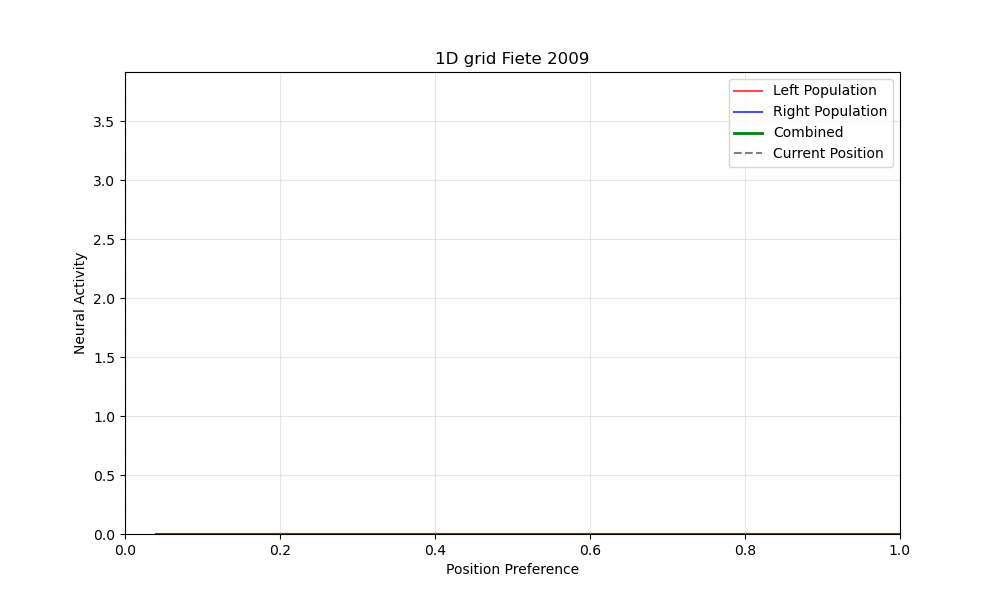

In [10]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10,6))
# Initialize lines
line_left, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'r-', alpha=0.7, label='Left Population')
line_right, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'b-', alpha=0.7, label='Right Population')
line_combined, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'g-', linewidth=2, label='Combined')
# Add position indicator
pos_line = ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Current Position')
ax.set_xlim(0, 1)
ax.set_ylim(0, np.max(r_all) * 1.1)
ax.set_xlabel('Position Preference')
ax.set_ylabel('Neural Activity')
ax.set_title('1D grid Fiete 2009')
ax.legend()
ax.grid(True, alpha=0.3)
def update(frame):
    t_idx = frame
    
    # Update activity lines
    left_activity = r_all[:N, t_idx]
    right_activity = r_all[N:, t_idx]
    combined_activity = left_activity + right_activity
    
    line_left.set_ydata(left_activity)
    line_right.set_ydata(right_activity)
    line_combined.set_ydata(combined_activity)
    
    # Update position line
    current_pos = x[t_idx]
    pos_line.set_xdata([current_pos, current_pos])
    

    return line_left, line_right, line_combined, pos_line

# Create animation
frame_step = 20
ani = FuncAnimation(fig, update, frames=range(0, min(n_steps, 2000), frame_step),  # Limit to 1000 frames for performance
                    interval=50, blit=True, repeat=True)
plt.show()
plt.tight_layout()


In [11]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, f'Fiete2009_1D_{N}'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")